In [ ]:
#https://www.kaggle.com/atishadhikari/fake-news-cleaning-word2vec-lstm-99-accuracy

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [4]:
!pip install tensorflow

  Using cached wheel-0.36.2-py2.py3-none-any.whl (35 kB)
  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4835 sha256=51a9023835aa26c70017ffce5a3515c68a33a06743fffa9d7dccdd2ef0d1b41f
  Stored in directory: c:\users\lilie\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
  Created wheel for wrapt: filename=wrapt-1.12.1-py3-none-any.whl size=19558 sha256=0feb2d5436751b8d43fac488abcbf395ab44824f673883f0241b2996f26295f9
  Stored in directory: c:\users\lilie\appdata\local\pip\cache\wheels\5f\fd\9e\b6cf5890494cb8ef0b5eaff72e5d55a70fb56316007d6dfe73
Successfully built termcolor wrapt
  Attempting uninstall: wheel
    Found existing installation: wheel 0.34.2
    Uninstalling wheel-0.34.2:
      Successfully uninstalled wheel-0.34.2
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.11.2
    Uninstalling wrapt-1.11.2:
      Successfully uninstalled wrapt-1.11.2
  Attempting uninstall: h5py
    Found exist

In [2]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [3]:
df = pd.read_csv(r'C:\Users\lilie\OneDrive\Bureau\ironHack\dataset\fake_real_final.csv')

In [4]:
df['txt'] = df['title'] + " " + df['text']
df = df.drop(columns = ['title', 'text','subject','date'])
df = df.loc[~df['txt'].isna()]
df.head()

,label_REAL,txt
0,0,You Can Smell Hillary’s Fear Daniel Greenfield...
1,0,Watch The Exact Moment Paul Ryan Committed Pol...
2,1,Kerry to go to Paris in gesture of sympathy U....
3,0,Bernie supporters on Twitter erupt in anger ag...
4,1,The Battle of New York: Why This Primary Matte...


In [5]:
y = df["label_REAL"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["txt"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del df

In [6]:
import gensim

In [27]:
#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, window=5, min_count=1)

In [25]:
from gensim import models
w = models.KeyedVectors.load_word2vec_format('model.bin', binary=True)

In [8]:
#vocab size
len(w2v_model.wv.key_to_index)

142830

We have now represented each of 142830 words by a 100dim vector (default value in Word2Vec).

In [9]:
w2v_model.wv.most_similar("iran")

[('tehran', 0.8926344513893127),
 ('iranian', 0.7594042420387268),
 ('nuclear', 0.6533453464508057),
 ('iranians', 0.6436753273010254),
 ('irandeal', 0.6365297436714172),
 ('hezbollah', 0.6304106116294861),
 ('jcpoa', 0.6227744817733765),
 ('destabilizing', 0.6011393070220947),
 ('russia', 0.5976725816726685),
 ('israel', 0.5941376090049744)]

In [10]:
#Feeding US Presidents
w2v_model.wv.most_similar(["trump","obama", "clinton"])
#First was Bush

[('bush', 0.5577229261398315),
 ('incoming', 0.5056546926498413),
 ('elect', 0.4948301613330841),
 ('hillary', 0.49260416626930237),
 ('sanders', 0.4883331060409546),
 ('obamahe', 0.47077351808547974),
 ('macron', 0.4685414135456085),
 ('mkdbxpkquvshere', 0.46285107731819153),
 ('christie', 0.4538923501968384),
 ('cruz', 0.4513186514377594)]

In [11]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it yo lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [12]:
# lets check the first 10 words of first news
#every word has been represented with a number
X[0][:10]

[10424, 29, 782, 3600, 15108, 37479, 3594, 1040, 621, 389]

In [13]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break     

trump -> 1
said -> 2
would -> 3
president -> 4
people -> 5
one -> 6
clinton -> 7
state -> 8
new -> 9
obama -> 10


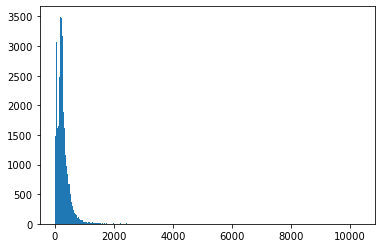

In [14]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [15]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 700])

48996

In [16]:
vocab_size = len(tokenizer.word_index) + 1

In [21]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, 100))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

In [22]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

TypeError: 'Word2Vec' object is not subscriptable

In [24]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=100, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

NameError: name 'embedding_vectors' is not defined

In [ ]:
model.summary()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.3, epochs=6)

In [ ]:
#Prediction is in probability of news being real, so converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [ ]:
accuracy_score(y_test, y_pred)

In [ ]:
accuracy_score(y_test, y_pred)